In [1]:
import nibabel as nib
import nibabel.processing
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import random
from skimage.filters import gabor
import skimage.exposure
import SimpleITK as sitk
import scipy.ndimage  # Per il resize volumetrico
from torch.onnx.symbolic_opset8 import zeros_like



# ESTRAZIONE FILE NII.GZ IN FILE .NII

In [ ]:
import os
import gzip
import shutil




def estrai_nii_gz(cartella_sorgente, cartella_destinazione):
    # Crea la cartella di destinazione se non esiste
    os.makedirs(cartella_destinazione, exist_ok=True)

    # Itera su tutti i file nella cartella sorgente
    for nome_file in os.listdir(cartella_sorgente):
        if nome_file.endswith('.nii.gz'):
            percorso_sorgente = os.path.join(cartella_sorgente, nome_file)
            nome_output = nome_file[:-3]  # Rimuove '.gz'
            percorso_destinazione = os.path.join(cartella_destinazione, nome_output)

            # Estrae il file
            with gzip.open(percorso_sorgente, 'rb') as f_in:
                with open(percorso_destinazione, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)

            print(f"File estratto: {nome_file} -> {nome_output}")

# Esempio di utilizzo
cartella_sorgente = 'D:\StefanoTesiMagistrale\DatasetStefano\IXI (NO LESIONI)\IXI_MRA\FilesGZ'
cartella_destinazione = 'D:\StefanoTesiMagistrale\DatasetStefano\IXI (NO LESIONI)\IXI_MRA\FilesNii'
estrai_nii_gz(cartella_sorgente, cartella_destinazione)


# ANALISI DEI METADATI DEI FILE NII
## Prima di effettuare delle operazioni sui file nii, verifica se la distanza tra le slide sia inferiore al millimetro e verifica se lo spazio dei voxel sia lo stesso (Es: 0.5,0.5,0.5)

In [ ]:
# ANALISI METADATI DEI FILE NII
import nibabel as nib

# Percorso del file NIfTI
nii_path = "D:\StefanoTesiMagistrale\DatasetStefano\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_01_FLAIR_preprocessed.nii"  # <-- modifica con il tuo percorso

# Carica immagine e header
img = nib.load(nii_path)
header = img.header
affine = img.affine
print(header)
# Estrai informazioni

shape = img.shape
voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)

slice_spacing = voxel_spacing[2] if len(voxel_spacing) >= 3 else "Non disponibile"
data_type = header.get_data_dtype()

# Stampa
print(f"🧠 File: {nii_path}")
print(f"Forma volume (x, y, z): {shape}")
print(f"Datatype: {data_type}")
print(f"Voxel spacing (x, y, z): {voxel_spacing}")
print(f"➡️  Distanza tra le slice (asse Z): {slice_spacing} mm")
print(f"\nMatrice affine:\n{affine}")


In [ ]:
#PER IMMAGINE SINGOLA

# Carica volume
vol = nib.load(r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_01_FLAIR_preprocessed.nii").get_fdata()

# Seleziona una singola slice
slice_index = 350
slice_data = vol[:, :, slice_index]

# Clipping tra 1° e 99° percentile
v_min, v_max = np.percentile(slice_data, (1, 99))
clipped = np.clip(slice_data, v_min, v_max)

# Normalizzazione tra 0 e 1
normalized = (clipped - v_min) / (v_max - v_min)

# Visualizza la slice
plt.imshow(normalized, cmap='gray', interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# === Parametri ===
input_path = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_01_FLAIR_preprocessed.nii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainA"

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Carica il volume
vol = nib.load(input_path).get_fdata()

# Itera su tutte le slice lungo l'asse Z
for i in range(vol.shape[2]):
    slice_data = vol[:, :, i]

    # Salta slice completamente nere o quasi (tutti zeri o valore costante)
    if np.std(slice_data) < 1e-6:
        continue

    # Clipping tra 1° e 99° percentile
    v_min, v_max = np.percentile(slice_data, (1, 99))
    if np.abs(v_max - v_min) < 1e-6:
        continue

    clipped = np.clip(slice_data, v_min, v_max)

    # Normalizzazione tra 0 e 1
    normalized = (clipped - v_min) / (v_max - v_min)

    # Salva la slice come PNG
    output_path = os.path.join(output_folder, f"slice_{i:03d}.png")
    plt.imsave(output_path, normalized, cmap='gray')

print("✅ Slice significative salvate con successo.")


# TARGET SPACING DEL VOLUME in (0.5,0.5,0.5)
# Questo vale anche nel caso in cui si vuole avere un target_space di 1,2,ecc...

Questo codice serve nel caso in cui, visualizzando lo spazio di un voxel, non abbiamo la stessa misura su tutti e 3 gli assi (x,y,z) (Ad esempio: (1,0.5,0.5)). In questo caso si utilizza questo codice che crea degli zooming factor dividendo il corrente voxel spacing originale per lo spacing target.
Facendo la *divisione* tra gli space voxels e gli zooming factor otterrai lo space target.

## Esempio
Supponi di avere uno spazio di voxel pari a *(1,0.5,0.5)* e supponi che hai un target space di *(0.5)* . Allora gli zooming factors saranno pari a:
- 1/0.5 = 0.5
- 0.5/0.5 = 1
- 0.5/0.1 = 1



In [ ]:
# PER SINGOLO FILE
from nibabel.processing import resample_to_output
# Percorso al file NIfTI di input
input_file = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_06_FLAIR_preprocessed.nii" # <-- Cambia con il percorso reale


# Cartella di output
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore"

# ESTRAZIONE DELL'IMMAGINE DI TIPO NIFTI
img = nib.load(input_file)
data = img.get_fdata()
slice_index = 340
slice_data = data[:, :, slice_index]

# Visualizza la slice
plt.imshow(slice_data, cmap='gray', interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()


plt.hist(slice_data.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Originale")
plt.show()

# CAMBIO DEI VOXEL SPACING, CON CONSEGUENTE RITRASFORMAZIONE DELL'IMMAGINE
target_spacing = (0.5, 0.5, 0.5)
header = img.header
voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)
print(f"  Voxel spacing originale:", voxel_spacing)
# SLICES RICAMPIONATE
resampled_img = resample_to_output(img, target_spacing, order = 0) # resampling con interpolazione nearest neigh.

# ESTRAZIONE DEI DATI DAL RICAMPIONAMENTO

resampled_data = resampled_img.get_fdata()
print(f"  Nuova forma:", resampled_img.header)

resampled_slice = resampled_data[:,:,slice_index]

# Visualizza la slice
plt.imshow(resampled_slice, cmap='gray', interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()
# Istogramma
plt.hist(resampled_slice.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Trasformed")
plt.show()


# Salva il file NIfTI
#output_path = os.path.join(output_folder, output_filename)
#z_img = nib.Nifti1Image(matrice_z_score, affine=resampled_img.affine, header=resampled_img.header)
#nib.save(z_img, output_path)


Slices Assiali, saggittali e longitudinali:  (386, 538, 531)
  Voxel spacing originale: (np.float32(0.5), np.float32(0.5), np.float32(0.5))
valid_values:  [2.80531192 2.82069373 2.80664825 ... 2.81699705 2.82890368 2.81813455]
vmin_data, vmax_data:  2.796104669570923 3.7852602005004883


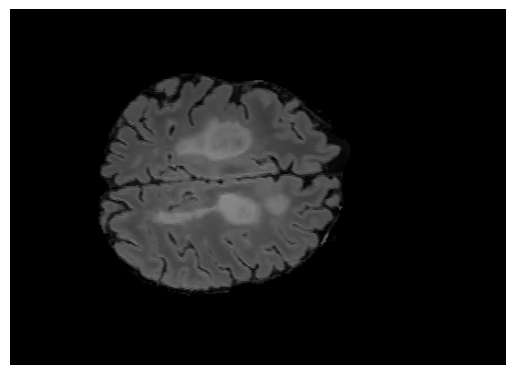

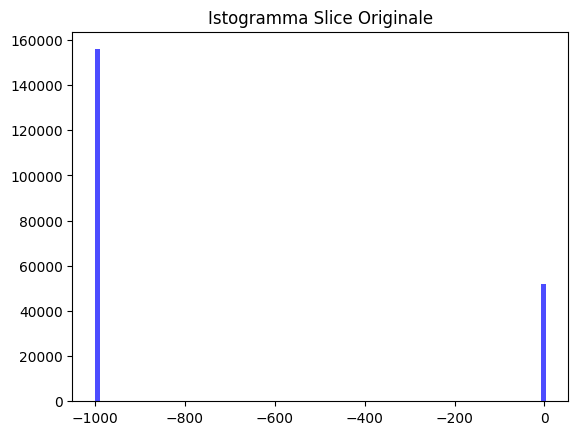

In [10]:
# PER SINGOLO FILE
from nibabel.processing import resample_to_output

# Percorso al file NIfTI di input
input_file = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore\center_01_sub_01_FLAIR_preprocessed_zscore.nii"
img = nib.load(input_file)
data = img.get_fdata()
print("Slices Assiali, saggittali e longitudinali: ",data.shape)
header = img.header
voxel_spacing = header.get_zooms()
print(f"  Voxel spacing originale:", voxel_spacing)
# Visualizzazione slice originale
slice_index = 380
slice_data = data[:, :, slice_index]

## Visualizza la slice dello z_score
valid_values = data[data > -1000] # Tutti i pixel che hanno valore <=0 sono posizionati nell'istogramma con un valore pari a -1000
print("valid_values: ",valid_values)
vmin_data = np.min(valid_values)
vmax_data = np.max(valid_values)
print("vmin_data, vmax_data: ",vmin_data, vmax_data)

plt.imshow(slice_data, cmap='gray', vmin=vmin_data, vmax=vmax_data, interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()


plt.hist(slice_data.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Originale")
plt.show()


In [9]:
#CON PIL

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image
# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainA"

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)



for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        print(f"🔍 Elaborando: {filename}")

        # Carica il volume e visualizza informazioni base
        vol = nib.load(input_path)
        data = vol.get_fdata()
        print("Slices Assiali, saggittali e longitudinali: ",data.shape)
        header = vol.header
        voxel_spacing = header.get_zooms()
        print(f"  Voxel spacing originale:", voxel_spacing)

        ## Visualizza la slice dello z_score
        valid_values = data[data > -1000] # Tutti i pixel che hanno valore <=0 sono posizionati nell'istogramma con un valore pari a -1000
        print("valid_values: ",valid_values)
        vmin_data = np.min(valid_values)
        vmax_data = np.max(valid_values)
        print("vmin_data, vmax_data: ",vmin_data, vmax_data)

        # Itera su tutte le slice lungo l'asse Z
        for i in range(vol.shape[2]):
            slice_data = data[:, :, i]

            # Mappa automaticamente il range [vmin, vmax] -> [0, 255]
            norm_slice = np.clip((slice_data - vmin_data) / (vmax_data - vmin_data), 0, 1)
            norm_slice *= 255
            norm_slice = norm_slice.astype(np.uint8)

            # Crea immagine PIL
            img = Image.fromarray(norm_slice, mode='L')  # 'L' = 8-bit grayscale

            # Salva immagine
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_slice_{i:03d}.png")
            img.save(output_path)


print("✅ Slice significative salvate con successo.")


🔍 Elaborando: center_01_sub_01_FLAIR_preprocessed_zscore.nii
Slices Assiali, saggittali e longitudinali:  (386, 538, 531)
  Voxel spacing originale: (np.float32(0.5), np.float32(0.5), np.float32(0.5))
valid_values:  [2.80531192 2.82069373 2.80664825 ... 2.81699705 2.82890368 2.81813455]
vmin_data, vmax_data:  2.796104669570923 3.7852602005004883
🔍 Elaborando: center_01_sub_02_FLAIR_preprocessed_zscore.nii
Slices Assiali, saggittali e longitudinali:  (351, 531, 531)
  Voxel spacing originale: (np.float32(0.5), np.float32(0.5), np.float32(0.5))
valid_values:  [2.30848122 2.30749345 2.30627728 ... 2.39735365 2.3890667  2.40543389]
vmin_data, vmax_data:  2.2995896339416504 3.7477805614471436
🔍 Elaborando: center_01_sub_03_FLAIR_preprocessed_zscore.nii
Slices Assiali, saggittali e longitudinali:  (350, 511, 531)
  Voxel spacing originale: (np.float32(0.5), np.float32(0.5), np.float32(0.5))
valid_values:  [2.42009997 2.42309284 2.42523742 ... 2.42739296 2.43561077 2.42566586]
vmin_data, vmax

In [ ]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
from matplotlib import colormaps as cm

# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNiiZscoreFLAIR"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\Train\TrainB"

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Soglia percentuale per definire una slice come "nera"
black_threshold = 0.03  # Ad esempio, se il 90% dei pixel è nero

for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        print(f"🔍 Elaborando: {filename}")

        # Carica il volume e visualizza informazioni base
        vol = nib.load(input_path)
        data = vol.get_fdata()
        print("Slices Assiali, Saggittali e Longitudinali:", data.shape)
        header = vol.header
        voxel_spacing = header.get_zooms()
        print(f"  Voxel spacing originale:", voxel_spacing)

        # Calcola min e max validi (escludendo -1000)
        valid_values = data[data > 0]
        vmin_data = np.min(valid_values)
        vmax_data = np.max(valid_values)
        print("vmin_data, vmax_data:", vmin_data, vmax_data)

        # Usa la colormap di matplotlib
        cmap = cm.get_cmap('gray')

        # Itera su tutte le slice lungo l'asse Z
        for i in range(data.shape[2]):
            slice_data = data[:, :, i]

            # Verifica se la slice è "nera" (maggior parte dei pixel è 0)
            non_black_pixels = np.sum(slice_data > 0)
            total_pixels = slice_data.size
            non_black_ratio = non_black_pixels / total_pixels

            if non_black_ratio < black_threshold:
                print(f"  🔴 Ignorata slice {i:03d} perché è principalmente nera.")
                continue  # Ignora questa slice

            # Normalizza nel range [0, 1] SOLO A LIVELLO VISIVO, NON STO TOCCANDO LO Z-SCORE
            norm = np.clip((slice_data - vmin_data) / (vmax_data - vmin_data), 0, 1)

            # Applica colormap (output: H x W x 4 RGBA float)
            rgba_img = cmap(norm)

            # Estrai solo RGB e converti in uint8
            rgb_img = (rgba_img[:, :, :3] * 255).astype(np.uint8)

            # Crea immagine PIL
            img = Image.fromarray(rgb_img)

            # Salva immagine
            base_name = os.path.splitext(filename)[0].replace('.nii', '').replace('.gz', '')
            output_path = os.path.join(output_folder, f"{base_name}_slice_{i:03d}.png")
            img.save(output_path)

print("✅ Slice significative salvate con successo.")


🔍 Elaborando: center_01_sub_01_FLAIR_preprocessed_zscore.nii
Slices Assiali, Saggittali e Longitudinali: (386, 538, 531)
  Voxel spacing originale: (np.float32(0.5), np.float32(0.5), np.float32(0.5))
vmin_data, vmax_data: 0.0010000000474974513 8.817638397216797
  🔴 Ignorata slice 000 perché è principalmente nera.
  🔴 Ignorata slice 001 perché è principalmente nera.
  🔴 Ignorata slice 002 perché è principalmente nera.
  🔴 Ignorata slice 003 perché è principalmente nera.
  🔴 Ignorata slice 004 perché è principalmente nera.
  🔴 Ignorata slice 005 perché è principalmente nera.
  🔴 Ignorata slice 006 perché è principalmente nera.
  🔴 Ignorata slice 007 perché è principalmente nera.
  🔴 Ignorata slice 008 perché è principalmente nera.
  🔴 Ignorata slice 009 perché è principalmente nera.
  🔴 Ignorata slice 010 perché è principalmente nera.
  🔴 Ignorata slice 011 perché è principalmente nera.
  🔴 Ignorata slice 012 perché è principalmente nera.
  🔴 Ignorata slice 013 perché è principalmente ne

# Estrazione Z-score dai volumi delle immagini
## Allora, dopo estenuanti ricerche si è riusciti ad arrivare alla conclusion.
### In questo codice vengono effettuati i seguenti passaggi:
- Apertura di un file nii preso da una cartella di un file;
- Trasformazione della dimensione dei voxel dell'immagine di input con annessa interpolazione nearest neighbor;
- Calcolo dello Z-Score del nifti trasformato;
- Applicazione dello Z-score al nifti trasformato per effettuare normalizzazione;
- Salvataggio del nuovo file normalizzato in un file nifti

## PER CONSIDERARE L'INTERA CARTELLA DI FILES NIFTI

valid_values:  [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0

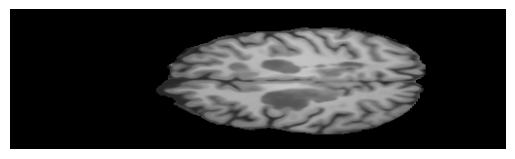

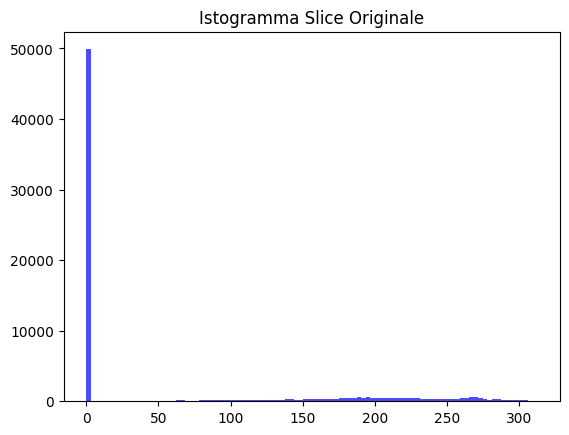

  Voxel spacing originale: (np.float32(1.0999999), np.float32(0.5), np.float32(0.5))
  Nuova forma: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 386 538 531   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  0.5 0.5 0.5 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
q

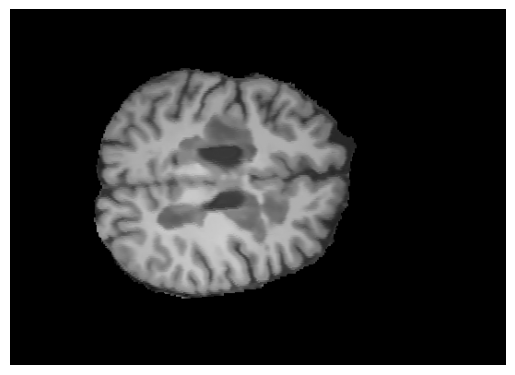

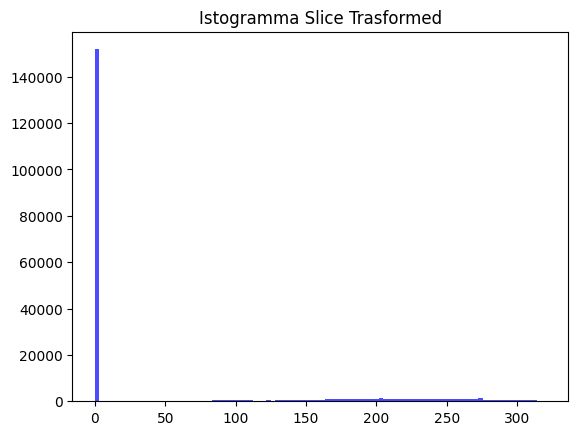

media del volume:  205.57812680705118
deviazione standard del volume:  66.48357555600374
z_score:  [-2.35586633 -2.46418981 -2.45827041 ... -2.46735834 -2.4349736
 -2.47477796]
tipo z_score:  <class 'numpy.ndarray'>
matrice_z_score:  [-2.35586633 -2.46418981 -2.45827041 ... -2.46735834 -2.4349736
 -2.47477796]
valid_values:  [167.56083679 168.77020264 168.30673218 ...  64.70964813  58.73670578
  54.58394241]
vmin_z, vmax_z:  2.0233174544034934e-07 2.8899207025154086


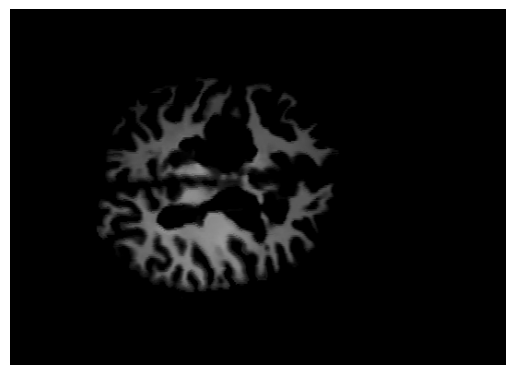

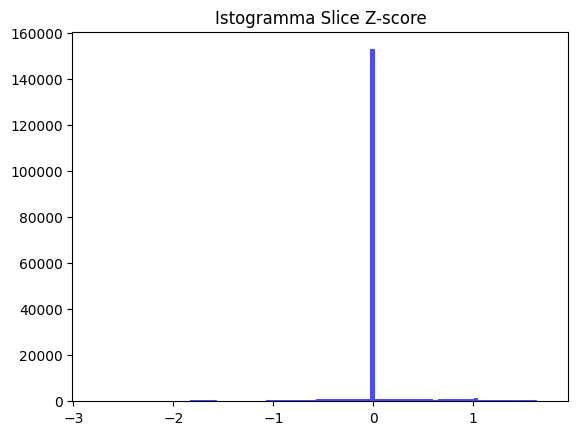

In [11]:
# PER SINGOLO FILE
from nibabel.processing import resample_to_output
# Percorso al file NIfTI di input
input_file = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TraininigT1\TrainingT1Nii\TrainANii\center_01_sub_01_T1_preprocessed.nii" # <-- Cambia con il percorso reale


# Cartella di output
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore"

# ESTRAZIONE DELL'IMMAGINE DI TIPO NIFTI
img = nib.load(input_file)
data = img.get_fdata()
data[data == 0] = 0
slice_index = 370
slice_data = data[:, :, slice_index]

## Visualizza la slice
valid_values = data[data > 0]
print("valid_values: ",data)
vmin_data = min(valid_values)
vmax_data = max(valid_values)
print("vmin_data, vmax_data: ",vmin_data, vmax_data)

plt.imshow(slice_data, cmap='gray', vmin=vmin_data, vmax=vmax_data, interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()


plt.hist(slice_data.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Originale")
plt.show()

# CAMBIO DEI VOXEL SPACING, CON CONSEGUENTE RITRASFORMAZIONE DELL'IMMAGINE
target_spacing = (0.5, 0.5, 0.5)
header = img.header
voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)
print(f"  Voxel spacing originale:", voxel_spacing)


# SLICES RICAMPIONATE
resampled_img = resample_to_output(img, target_spacing, order = 0) # resampling con interpolazione nearest neigh.
print(f"  Nuova forma:", resampled_img.header)


# ESTRAZIONE DEI DATI DAL RICAMPIONAMENTO
resampled_data = resampled_img.get_fdata()
resampled_data[resampled_data == 0] = 0
resampled_slice = resampled_data[:,:,slice_index]


# Visualizza la slice
valid_values_resampled = resampled_data[resampled_data > 0]
print("valid_values: ",valid_values_resampled)
vmin_resampled = np.min(valid_values_resampled)
vmax_resampled = np.max(valid_values_resampled)
print("vmin_resampled, vmax_resampled: ",vmin_resampled, vmax_resampled)

plt.imshow(resampled_slice, cmap='gray', vmin=vmin_resampled, vmax =vmax_resampled, interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()
# Istogramma
plt.hist(resampled_slice.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Trasformed")
plt.show()


# DA QUI, CALCOLO DELLO Z-SCORE DELL'IMMAGINE TRASFORMATA
mask_resampled = resampled_data != 0 # maschera, levo gli 0 dalle slice

media = np.mean(resampled_data[mask_resampled]) # media su tutto il volume
print("media del volume: ",media)

std = np.std(resampled_data[mask_resampled]) # deviazione su tutto il volume
print("deviazione standard del volume: ", std)

z_score = (resampled_data[mask_resampled] - media) / std
print("z_score: ",z_score) # z_score calcolato su tutto il volume
print("tipo z_score: ", type(z_score))


# Crea una matrice 3D con stessa shape del volume resampled
matrice_z_score = resampled_data

# Inserisci i valori z-score nella maschera
matrice_z_score[mask_resampled] = z_score
matrice_z_score[matrice_z_score == 0] = 0
print("matrice_z_score: ",matrice_z_score[mask_resampled])


# Crea e salva il nuovo file NIfTI
# Estrai il nome del file di input senza estensione
input_filename = os.path.basename(input_file)
filename_without_extension = os.path.splitext(input_filename)[0]

# Crea il nuovo nome del file aggiungendo "_zscore" e l'estensione ".nii"
output_filename = f"{filename_without_extension}_zscore.nii"


# PER VISUALIZZARE UNA SLICE DEL FILE NIFTI CON LO Z-SCORE
valid_values_z_score = matrice_z_score[matrice_z_score > 0]
print("valid_values: ",valid_values)
vmin_z = np.min(valid_values_z_score)
vmax_z = np.max(valid_values_z_score)
print("vmin_z, vmax_z: ",vmin_z, vmax_z)

slice_z = matrice_z_score[:,:,slice_index]
plt.imshow(slice_z, cmap='gray', interpolation='bilinear', vmin=vmin_z,vmax=vmax_z)
plt.axis('off')  # Nasconde gli assi
plt.show()


plt.hist(slice_z.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Z-score")
plt.show()


# Salva il file NIfTI
#output_path = os.path.join(output_folder, output_filename)
#z_img = nib.Nifti1Image(matrice_z_score, affine=resampled_img.affine, header=resampled_img.header)
#nib.save(z_img, output_path)


valid_values:  [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0

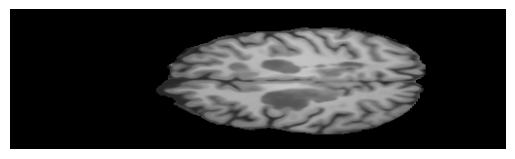

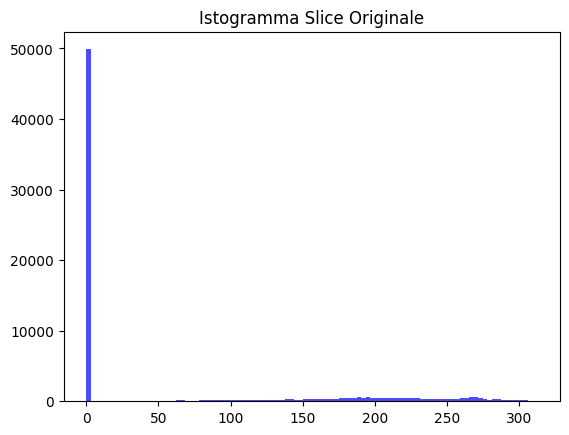

  Voxel spacing originale: (np.float32(1.0999999), np.float32(0.5), np.float32(0.5))
  Nuova forma: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 386 538 531   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  0.5 0.5 0.5 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
q

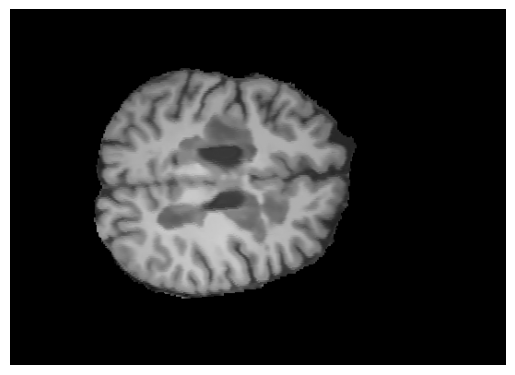

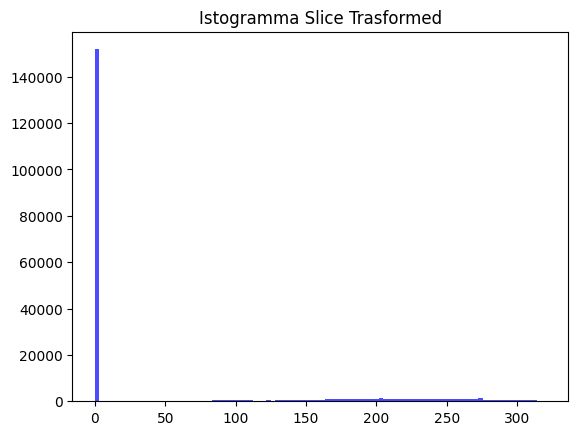

media del volume:  205.57812680705118
deviazione standard del volume:  66.48357555600374
z_score calcolato (non shiftato)
min_z:  -3.3721217608994083
Valore di shift applicato: 3.373121760899408
matrice_z_score shiftata creata
vmin_z, vmax_z:  0.0009999999999998899 6.263042463414816


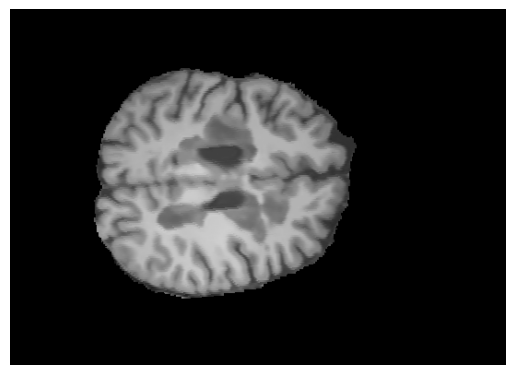

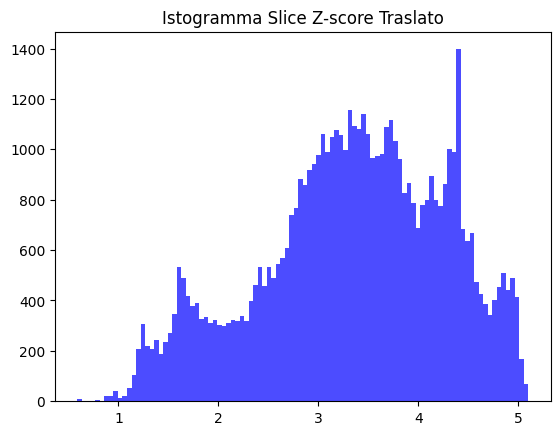

In [13]:
# versione di prova

# PER SINGOLO FILE
from nibabel.processing import resample_to_output
# Percorso al file NIfTI di input
input_file = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TraininigT1\TrainingT1Nii\TrainANii\center_01_sub_01_T1_preprocessed.nii" # <-- Cambia con il percorso reale


# Cartella di output
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore"

# ESTRAZIONE DELL'IMMAGINE DI TIPO NIFTI
img = nib.load(input_file)
data = img.get_fdata()
data[data == 0] = 0
slice_index = 370
slice_data = data[:, :, slice_index]

## Visualizza la slice
valid_values = data[data > 0]
print("valid_values: ",data)
vmin_data = min(valid_values)
vmax_data = max(valid_values)
print("vmin_data, vmax_data: ",vmin_data, vmax_data)

plt.imshow(slice_data, cmap='gray', vmin=vmin_data, vmax=vmax_data, interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()


plt.hist(slice_data.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Originale")
plt.show()

# CAMBIO DEI VOXEL SPACING, CON CONSEGUENTE RITRASFORMAZIONE DELL'IMMAGINE
target_spacing = (0.5, 0.5, 0.5)
header = img.header
voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)
print(f"  Voxel spacing originale:", voxel_spacing)


# SLICES RICAMPIONATE
resampled_img = resample_to_output(img, target_spacing, order = 0) # resampling con interpolazione nearest neigh.
print(f"  Nuova forma:", resampled_img.header)


# ESTRAZIONE DEI DATI DAL RICAMPIONAMENTO
resampled_data = resampled_img.get_fdata()
resampled_data[resampled_data == 0] = 0
resampled_slice = resampled_data[:,:,slice_index]


# Visualizza la slice
valid_values_resampled = resampled_data[resampled_data > 0]
print("valid_values: ",valid_values_resampled)
vmin_resampled = np.min(valid_values_resampled)
vmax_resampled = np.max(valid_values_resampled)
print("vmin_resampled, vmax_resampled: ",vmin_resampled, vmax_resampled)

plt.imshow(resampled_slice, cmap='gray', vmin=vmin_resampled, vmax =vmax_resampled, interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()
# Istogramma
plt.hist(resampled_slice.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Trasformed")
plt.show()

# DA QUI, CALCOLO DELLO Z-SCORE DELL'IMMAGINE TRASFORMATA
mask_resampled = resampled_data != 0  # maschera, levo gli 0 dalle slice

media = np.mean(resampled_data[mask_resampled])  # media su tutto il volume
print("media del volume: ", media)

std = np.std(resampled_data[mask_resampled])  # deviazione standard su tutto il volume
print("deviazione standard del volume: ", std)

# Calcolo Z-score solo sui voxel diversi da 0
z_score = (resampled_data[mask_resampled] - media) / std
print("z_score calcolato (non shiftato)")

# Calcolo dello shift per spostare i valori a destra dello 0
min_z = z_score.min()
print("min_z: ", min_z)
shift_value = abs(min_z) + 1e-3  # sposta tutto > 0
print("Valore di shift applicato:", shift_value)

# Applico lo shift
z_score_shifted = z_score
z_score_shifted[z_score_shifted != 0] = z_score_shifted + shift_value
# Ricrea matrice con stessa shape del volume originale
matrice_z_score = np.zeros_like(resampled_data)
matrice_z_score[mask_resampled] = z_score_shifted
print("matrice_z_score shiftata creata")

# Visualizza una slice shiftata
slice_z = matrice_z_score[:, :, slice_index]

valid_values_z_score = matrice_z_score[mask_resampled]
vmin_z = np.min(valid_values_z_score)
vmax_z = np.max(valid_values_z_score)
print("vmin_z, vmax_z: ", vmin_z, vmax_z)

# Visualizzazione immagine
plt.imshow(slice_z, cmap='gray', interpolation='bilinear', vmin=vmin_z, vmax=vmax_z)
plt.axis('off')
plt.show()

# Istogramma solo dei valori > 0 (escludi lo sfondo)
plt.hist(slice_z[slice_z > 0].flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Z-score Traslato")
plt.show()


# Salva il file NIfTI
#output_path = os.path.join(output_folder, output_filename)
#z_img = nib.Nifti1Image(matrice_z_score, affine=resampled_img.affine, header=resampled_img.header)
#nib.save(z_img, output_path)


# PER CONSIDERARE L'INTERA CARTELLA DI FILES NIFTI

In [5]:
from nibabel.processing import resample_to_output


# Percorso al file NIfTI di input
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNii" # <-- Cambia con il percorso reale


# Cartella di output
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNiiZscoreFLAIR"
# PER INSIEME DI FILE
for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]  # per .nii o .nii.gz

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        data = img.get_fdata()
        data[data <= 0] = -1000

        # CAMBIO DEI VOXEL SPACING, CON CONSEGUENTE RITRASFORMAZIONE DELL'IMMAGINE
        target_spacing = (0.5, 0.5, 0.5)
        header = img.header
        voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)
        print(f"  Voxel spacing originale:", voxel_spacing)
        # SLICES RICAMPIONATE
        resampled_img = resample_to_output(img, target_spacing, order = 0) # resampling con interpolazione nearest neigh.

        # ESTRAZIONE DEI DATI DAL RICAMPIONAMENTO
        resampled_data = resampled_img.get_fdata()
        resampled_data[resampled_data == 0] = 0

        # DA QUI, CALCOLO DELLO Z-SCORE DELL'IMMAGINE TRASFORMATA
        mask_resampled = resampled_data != 0  # maschera, levo gli 0 dalle slice

        media = np.mean(resampled_data[mask_resampled])  # media su tutto il volume
        print("media del volume: ", media)

        std = np.std(resampled_data[mask_resampled])  # deviazione standard su tutto il volume
        print("deviazione standard del volume: ", std)

        # Calcolo Z-score solo sui voxel diversi da 0
        z_score = (resampled_data[mask_resampled] - media) / std
        print("z_score calcolato (non shiftato)")

        # Calcolo dello shift per spostare i valori a destra dello 0
        min_z = z_score.min()
        shift_value = abs(min_z) + 1e-3  # sposta tutto > 0
        print("Valore di shift applicato:", shift_value)

        # Applico lo shift
        z_score_shifted = z_score + shift_value

        # Ricrea matrice con stessa shape del volume originale
        matrice_z_score = np.zeros_like(resampled_data)
        matrice_z_score[mask_resampled] = z_score_shifted
        print("matrice_z_score shiftata creata")

        # Crea e salva il nuovo file NIfTi

        # Crea il nuovo nome del file aggiungendo "_zscore" e l'estensione ".nii"
        output_filename = f"{base_name}_zscore.nii"

        # Salva il file NIfTI
        output_path = os.path.join(output_folder, output_filename)
        z_img = nib.Nifti1Image(matrice_z_score, affine=resampled_img.affine, header=resampled_img.header)
        nib.save(z_img, output_path)

print(f"✅ Completato: tutte i file nii di {input_folder} sono stati normalizzati e salvati in {output_folder}.")


📂 Processing: center_03_sub_01_FLAIR_preprocessed.nii
  Voxel spacing originale: (np.float32(0.8999481), np.float32(0.4688), np.float32(0.4688))
media del volume:  934.3690967129171
deviazione standard del volume:  452.9739613713712
z_score calcolato (non shiftato)
Valore di shift applicato: 2.03835749012371
matrice_z_score shiftata creata
📂 Processing: center_03_sub_03_FLAIR_preprocessed.nii
  Voxel spacing originale: (np.float32(0.899406), np.float32(0.4688), np.float32(0.4688))
media del volume:  890.6515255408659
deviazione standard del volume:  348.0161054559387
z_score calcolato (non shiftato)
Valore di shift applicato: 2.555915078178395
matrice_z_score shiftata creata
📂 Processing: center_03_sub_04_FLAIR_preprocessed.nii
  Voxel spacing originale: (np.float32(0.89985085), np.float32(0.4688), np.float32(0.4688))
media del volume:  967.5581324145616
deviazione standard del volume:  383.7074470338388
z_score calcolato (non shiftato)
Valore di shift applicato: 2.5226037371544443
mat

# Per avere file nifti non normalizzati con z-score

In [ ]:
# VALORI ORIGINALI
import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
import matplotlib.pyplot as plt

# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainB_Original"
target_spacing = (0.5, 0.5, 0.5)

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        resampled_img = resample_to_output(img, voxel_sizes=target_spacing)
        resampled_data = resampled_img.get_fdata()

        for i in range(resampled_data.shape[2]):
            slice_data = resampled_data[:, :, i]

            if np.std(slice_data) < 1e-6:
                continue

            v_min, v_max = np.percentile(slice_data, (1, 99))
            if np.abs(v_max - v_min) < 1e-5:
                continue

            clipped = np.clip(slice_data, v_min, v_max)
            rescaled = (clipped - v_min) / (v_max - v_min)  # necessario per plt.imsave

            output_path = os.path.join(output_folder, f"{base_name}_slice{i:03d}.png")
            plt.imsave(output_path, rescaled, cmap='gray')

print("✅ Completato con valori non normalizzati (solo clipping).")


In [ ]:
# SALVATAGGIO IN SOTTOCARTELLE, ORIGINAL
import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
import matplotlib.pyplot as plt

# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainaNii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainA_Original"
target_spacing = (0.5, 0.5, 0.5)

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        resampled_img = resample_to_output(img, voxel_sizes=target_spacing)
        resampled_data = resampled_img.get_fdata()

        # Crea sottocartella per ogni soggetto
        subject_output_folder = os.path.join(output_folder, base_name)
        os.makedirs(subject_output_folder, exist_ok=True)

        for i in range(resampled_data.shape[2]):
            slice_data = resampled_data[:, :, i]

            if np.std(slice_data) < 1e-6:
                continue

            v_min, v_max = np.percentile(slice_data, (1, 99))
            if np.abs(v_max - v_min) < 1e-5:
                continue

            clipped = np.clip(slice_data, v_min, v_max)
            rescaled = (clipped - v_min) / (v_max - v_min)

            output_path = os.path.join(subject_output_folder, f"slice_{i:03d}.png")
            plt.imsave(output_path, rescaled, cmap='gray')

print("✅ Completato: slice salvate in sottocartelle per ogni soggetto.")


# Conto del numero di file nelle cartelle

In [ ]:
folders = {
    "TrainA": r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TrainA",
    "TrainB": r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TrainB",
    "TestA":  r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TestA",
    "TestB":  r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TestB"
}

for name, path in folders.items():
    count = len([f for f in os.listdir(path) if f.lower().endswith('.png')])
    print(f"{name}: {count} immagini PNG")

# Spostare il 20% dei file da una cartella all'altra
utile se si deve splittare il dataset in train e test

In [ ]:


# Cartelle originali
trainA_folder = r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TrainA"
trainB_folder = r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TrainB"

# Cartelle di destinazione
testA_folder = r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TestA"
testB_folder = r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TestB"

def move_percentage_of_files(src_folder, dst_folder, percentage):
    files = [f for f in os.listdir(src_folder) if f.lower().endswith('.png')]
    random.shuffle(files)
    n_to_move = int(len(files) * percentage)

    for file in files[:n_to_move]:
        src_path = os.path.join(src_folder, file)
        dst_path = os.path.join(dst_folder, file)
        shutil.move(src_path, dst_path)

    print(f"✅ Spostati {n_to_move} file da {src_folder} a {dst_folder}")

# Sposta il 20%
move_percentage_of_files(trainA_folder, testA_folder, 0.2)
#move_percentage_of_files(trainB_folder, testB_folder, 0.2)

print("✅ Operazione completata!")


# Ricostruzione da immagine PNG a file nii


In [ ]:
import os
import numpy as np
import nibabel as nib
from PIL import Image

# Cartella contenente tutte le slice PNG ordinate (es: slice_001.png, slice_002.png, ...)
folder_path = 'path_to_png_slices'
png_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])

# Carica le immagini e crea uno stack 3D
slices = []
for file in png_files:
    img = Image.open(os.path.join(folder_path, file)).convert('L')  # 'L' = grayscale
    slices.append(np.array(img))

# Stack 3D: (altezza, larghezza, numero di slice)
volume = np.stack(slices, axis=-1)

# Crea immagine NIfTI
affine = np.eye(4)  # Matrice identità (puoi sostituirla con affine reale se disponibile)
nii_img = nib.Nifti1Image(volume, affine)

# Salva
nib.save(nii_img, 'ricostruzione.nii')
